# The Nature Conservancy Fisheries Monitoring

https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

In [ ]:
%matplotlib inline
import cv2
import random
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import tensorflow as tf
from tensorflow import keras

# Загружаем разметку

In [283]:
import os
import json
from glob import glob

# TODO: скачайте данные и сохраните в директорию:
TRAIN_PREFIX = '../input/the-nature-conservancy-fisheries-monitoring/train'

def load_boxes():
    boxes = dict()
    for path in glob('../input/fish-boxes/*.json'):
        label = os.path.basename(path).split('_', 1)[0]
        with open(path) as src:
            boxes[label] = json.load(src)
            for annotation in boxes[label]:
                basename = os.path.basename(annotation['filename'])
                annotation['filename'] = os.path.join(TRAIN_PREFIX, label.upper(), basename)
            for annotation in boxes[label]:
                for rect in annotation['annotations']:
                    rect['x'] += rect['width'] / 2
                    rect['y'] += rect['height'] / 2
    return boxes

def draw_boxes(annotation, rectangles=None, image_size=None):
    
    def _draw(img, rectangles, scale_x, scale_y, color=(0, 255, 0)):
        for rect in rectangles:
            pt1 = (int((rect['x'] - rect['width'] / 2) * scale_x),
                   int((rect['y'] - rect['height'] / 2) * scale_y))
            pt2 = (int((rect['x'] + rect['width'] / 2) * scale_x),
                   int((rect['y'] + rect['height'] / 2) * scale_y))
            img = cv2.rectangle(img.copy(), pt1, pt2, 
                                color=color, thickness=4)
        return img
    
    scale_x, scale_y = 1., 1.
    
    img = cv2.imread(annotation['filename'], cv2.IMREAD_COLOR)[...,::-1]
    if image_size is not None:
        scale_x = 1. * image_size[0] / img.shape[1]
        scale_y = 1. * image_size[1] / img.shape[0]
        img = cv2.resize(img, image_size)
        
    img = _draw(img, annotation['annotations'], scale_x, scale_y)
    
    if rectangles is not None:
        img = _draw(img, rectangles, 1., 1., (255, 0, 0))

    return img

### Визуализируем разметку

In [ ]:
boxes = load_boxes()  # разметка детекций

In [ ]:
pd.DataFrame([(k, len(v)) for k, v in boxes.items()],
             columns=['class', 'count'])

In [ ]:
fish_labels = ['ALB', 'BET', 'DOL', 'LAG', 'SHARK', 'YFT']

In [ ]:
labels_dict = dict(zip(fish_labels, np.eye(len(fish_labels))))

In [ ]:
labels_dict

In [ ]:
idx_to_labels = dict(zip(range(len(labels_dict)), labels_dict))
idx_to_labels

In [ ]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(boxes['lag'][7])
plt.imshow(img)
plt.title('{}x{}'.format(*img.shape));

### Распределение размеров разметки

In [ ]:
annotations = sum([box['annotations']
                  for box in sum(boxes.values(), [])], [])

widths = [rect['width'] for rect in annotations]
heights = [rect['height'] for rect in annotations]

plt.hist(widths)
plt.hist(heights);

In [ ]:
np.round(np.median(widths)), np.round(np.median(heights))

# Экстрактор признаков

In [ ]:
IMG_HEIGHT = 750
IMG_WIDTH = 1200

features = keras.applications.vgg16.VGG16(include_top=False,
                                          weights='imagenet',
                                          input_shape=(IMG_HEIGHT, IMG_WIDTH, 3))

feature_tensor = features.layers[-1].output

# дообучаем последние 6 слоев
for layer in features.layers[:-6]:
    layer.trainable = False

In [ ]:
features.summary()

# Сетка якорей (anchor grid)

In [ ]:
FEATURE_SHAPE = (feature_tensor.shape[1].value,
                 feature_tensor.shape[2].value)

GRID_STEP_H = IMG_HEIGHT / FEATURE_SHAPE[0]
GRID_STEP_W = IMG_WIDTH / FEATURE_SHAPE[1]

ANCHOR_WIDTH = np.round(np.median(widths))
ANCHOR_HEIGHT = np.round(np.median(heights))

ANCHOR_CENTERS = np.mgrid[GRID_STEP_H/2:IMG_HEIGHT:GRID_STEP_H,
                          GRID_STEP_W/2:IMG_WIDTH:GRID_STEP_W]

In [ ]:
def iou(rect, x_scale, y_scale, anchor_x, anchor_y,
        anchor_w=ANCHOR_WIDTH, anchor_h=ANCHOR_HEIGHT):
    
    rect_x1 = (rect['x'] - rect['width'] / 2) * x_scale
    rect_x2 = (rect['x'] + rect['width'] / 2) * x_scale
    
    rect_y1 = (rect['y'] - rect['height'] / 2) * y_scale
    rect_y2 = (rect['y'] + rect['height'] / 2) * y_scale
    
    anch_x1, anch_x2 = anchor_x - anchor_w / 2, anchor_x + anchor_w / 2
    anch_y1, anch_y2 = anchor_y - anchor_h / 2, anchor_y + anchor_h / 2
    
    dx = min(rect_x2, anch_x2) - max(rect_x1, anch_x1)
    dy = min(rect_y2, anch_y2) - max(rect_y1, anch_y1)
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square = (anch_x2 - anch_x1) * (anch_y2 - anch_y1)
    rect_square = (rect_x2 - rect_x1) * (rect_y2 - rect_y1)
    union = anch_square + rect_square - intersection
    
    return intersection / union

In [ ]:
def anchors_iou(anchor_x1, anchor_y1, anchor_x2, anchor_y2,
                anchor_w1=ANCHOR_WIDTH, anchor_h1=ANCHOR_HEIGHT,
                anchor_w2=ANCHOR_WIDTH, anchor_h2=ANCHOR_HEIGHT):
    
    """
    Функция для вычисления IoU между окнами
    """
    anch_x11, anch_x12 = anchor_x1 - anchor_w1 / 2, anchor_x1 + anchor_w1 / 2
    anch_y11, anch_y12 = anchor_y1 - anchor_h1 / 2, anchor_y1 + anchor_h1 / 2
    
    anch_x21, anch_x22 = anchor_x2 - anchor_w2 / 2, anchor_x2 + anchor_w2 / 2
    anch_y21, anch_y22 = anchor_y2 - anchor_h2 / 2, anchor_y2 + anchor_h2 / 2
    
    dx = min(anch_x12, anch_x22) - max(anch_x11, anch_x21)
    dy = min(anch_y12, anch_y22) - max(anch_y11, anch_y21)
    
    intersection = dx * dy if (dx > 0 and dy > 0) else 0.
    
    anch_square_1 = (anch_x12 - anch_x11) * (anch_y12 - anch_y11)
    anch_square_2 = (anch_x22 - anch_x21) * (anch_y22 - anch_y21)
    union = anch_square_1 + anch_square_2 - intersection
    
    return intersection / union

In [ ]:
def encode_anchors(annotation, img_shape, iou_thr=0.5, anc_iou_thr=0.33):
    
    encoded_box = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 5), dtype=np.float32)
    
    encoded_label = np.zeros(shape=(FEATURE_SHAPE[0],
                              FEATURE_SHAPE[1], 6), dtype=np.float32)

    x_scale = 1. * IMG_WIDTH / img_shape[1]
    y_scale = 1. * IMG_HEIGHT / img_shape[0]

    label = labels_dict[annotation['filename'].split('/')[4]]
    for rect in annotation['annotations']:
        scores = []
        for row in range(FEATURE_SHAPE[0]):
            for col in range(FEATURE_SHAPE[1]):
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                score = iou(rect, x_scale, y_scale, anchor_x, anchor_y)
                scores.append((score, anchor_x, anchor_y, row, col))

        scores = sorted(scores, reverse=True)

        if scores[0][0] < iou_thr:
            # если есть несколько окон с одинковым скором, оставляем расположенной посередине
            max_score = scores[0][0]
            quant = 1
            for score in scores[1:]:
                if score[0] < max_score:
                    break
                else:
                    quant += 1
            if quant > 1:
                scores = [scores[quant//2]]
            else:
                scores = [scores[0]]      # default anchor
        else:
            # оставляем окна, которые не сильно пересекаются
            scores = [e for e in scores if e[0] > iou_thr]
            fin_scores = [scores[0]]
            for e1 in scores[1:]:
                if all([anchors_iou(e1[1], e1[2], e2[1], e2[2]) < anc_iou_thr for e2 in fin_scores]):
                    fin_scores.append(e1)
            scores = fin_scores
            
        for score, anchor_x, anchor_y, row, col in scores:
            dx = (anchor_x - rect['x'] * x_scale) / ANCHOR_WIDTH
            dy = (anchor_y - rect['y'] * y_scale) / ANCHOR_HEIGHT
            dw = (ANCHOR_WIDTH - rect['width'] * x_scale) / ANCHOR_WIDTH
            dh = (ANCHOR_HEIGHT - rect['height'] * y_scale) / ANCHOR_HEIGHT
            encoded_box[row, col] = [1., dx, dy, dw, dh]
            encoded_label[row, col] = [*label]
    return encoded_box, encoded_label

In [ ]:
def _sigmoid(x):
    return 1. / (1. + np.exp(-x))


def decode_prediction(prediction, conf_thr=0.1, iou_thr=0.5, anc_iou_thr=0.33, test=False):
    rectangles = []
    fin_rectangles = []
    for row in range(FEATURE_SHAPE[0]):
        for col in range(FEATURE_SHAPE[1]):
            if not test:
                logit, dx, dy, dw, dh = prediction[0][0][row, col]
                label = prediction[1][0][row, col]
            else:
                logit, dx, dy, dw, dh = prediction[row, col]
                label = np.array([0, 0, 0, 0, 0, 0])
            conf = _sigmoid(logit)
            if conf > conf_thr:
                anchor_x = ANCHOR_CENTERS[1, row, col]
                anchor_y = ANCHOR_CENTERS[0, row, col]
                rectangles.append({'x': anchor_x - dx * ANCHOR_WIDTH,
                                    'y': anchor_y - dy * ANCHOR_HEIGHT,
                                    'width': ANCHOR_WIDTH - dw * ANCHOR_WIDTH,
                                    'height': ANCHOR_HEIGHT - dh * ANCHOR_HEIGHT,
                                    'conf': conf,
                                    'label': label,
                                    'coord': (row, col)})
    try:
        # оставляем окна, которые не сильно пересекаются
        fin_rectangles = [rectangles[0]]
        for rect1 in rectangles[1:]:
            if all([anchors_iou(rect1['x'], rect1['y'], rect2['x'], rect2['y'], 
                                rect1['width'], rect1['height'], rect2['width'], 
                                rect2['height']) < anc_iou_thr for rect2 in fin_rectangles]):
                fin_rectangles.append(rect1)
        rectangles = fin_rectangles
    except:
        pass
    return rectangles

### Валидация енкодинга/декодинга

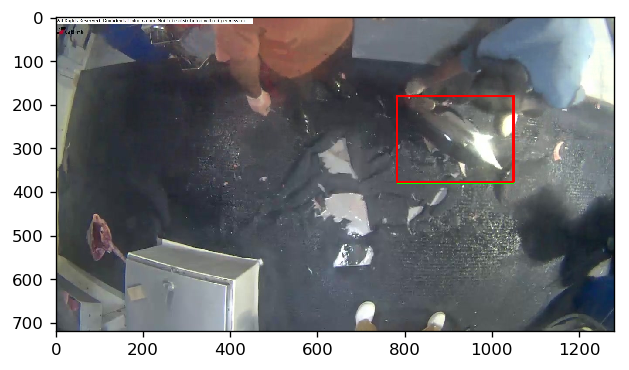

In [275]:
example = boxes['alb'][17]

encoded = encode_anchors(example, (IMG_HEIGHT, IMG_WIDTH))[0]

decoded = decode_prediction(encoded, conf_thr=0.5, test=True)
decoded = sorted(decoded, key = lambda e: -e['conf'])

plt.figure(figsize=(6, 6), dpi=120)
plt.imshow(draw_boxes(example, decoded[:10][:5]))

## Функция потерь

In [ ]:
K = tf.keras.backend

def confidence_loss(y_true, y_pred):
    conf_loss = K.binary_crossentropy(y_true[..., 0], 
                                      y_pred[..., 0],
                                      from_logits=True)
    return conf_loss

def smooth_l1(y_true, y_pred):
    abs_loss = K.abs(y_true[..., 1:] - y_pred[..., 1:])
    square_loss = 0.5 * K.square(y_true[..., 1:] - y_pred[..., 1:])
    mask = K.cast(K.greater(abs_loss, 1.), 'float32')
    total_loss = (abs_loss - 0.5) * mask + 0.5 * square_loss * (1. - mask)
    return K.sum(total_loss, axis=-1)

def class_loss(y_true, y_pred):
    y_true = K.reshape(y_true[1], (-1, 6))
    y_pred = K.reshape(y_pred[1], (-1, 6))
    class_loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)
    return class_loss

def total_loss(y_true, y_pred, neg_pos_ratio=3):
    batch_size = K.shape(y_true[0])[0]
    
    # TODO: добавьте функцию потерь для классификации детекции
    
    y_true = K.reshape(y_true[0], (batch_size, -1, 5))
    y_pred = K.reshape(y_pred[0], (batch_size, -1, 5))

    # confidence loss
    conf_loss = confidence_loss(y_true, y_pred)
    
    # smooth l1 loss
    loc_loss = smooth_l1(y_true, y_pred)
    
    # positive examples loss
    pos_conf_loss = K.sum(conf_loss * y_true[..., 0], axis=-1)
    pos_loc_loss = K.sum(loc_loss * y_true[..., 0], axis=-1)
    
    # negative examples loss
    anchors = K.shape(y_true)[1]
    num_pos = K.sum(y_true[..., 0], axis=-1)
    num_pos_avg = K.mean(num_pos)
    num_neg = K.min([neg_pos_ratio * (num_pos_avg) + 1., K.cast(anchors, 'float32')])
    
    # hard negative mining
    neg_conf_loss, _ = tf.nn.top_k(conf_loss * (1. - y_true[..., 0]),
                                   k=K.cast(num_neg, 'int32'))

    neg_conf_loss = K.sum(neg_conf_loss, axis=-1)
    
    # total conf loss
    total_conf_loss = (neg_conf_loss + pos_conf_loss) / (num_neg + num_pos + 1e-32)
    loc_loss = pos_loc_loss / (num_pos + 1e-32)
    
    return total_conf_loss + 0.5 * loc_loss

## Загрузка данных

In [ ]:
def load_img(path, target_size=(IMG_WIDTH, IMG_HEIGHT)):
    img = cv2.imread(path, cv2.IMREAD_COLOR)[...,::-1]
    img_shape = img.shape
    img_resized = cv2.resize(img, target_size)
    return img_shape, keras.applications.vgg16.preprocess_input(img_resized.astype(np.float32))

def data_generator(boxes, batch_size=32):
    boxes = sum(boxes.values(), [])
    while True:
        random.shuffle(boxes)
        for i in range(len(boxes)//batch_size):
            X, y1, y2 = [], [], []
            for j in range(i*batch_size,(i+1)*batch_size):
                img_shape, img = load_img(boxes[j]['filename'])
                # TODO: добавьте one-hot encoding в разметку для классов
                y1.append(encode_anchors(boxes[j], img_shape)[0])
                y2.append(encode_anchors(boxes[j], img_shape)[1])
                X.append(img)
            yield (np.array(X), {'output_1': np.array(y1), 'output_2': np.array(y2)})

## Добавляем выход детектора

In [ ]:
from keras.regularizers import l2

In [ ]:
try:
    model = keras.models.load_model('fishes-vgg16.hdf5')
except:

    output = keras.layers.BatchNormalization()(feature_tensor)

    # TODO: добавьте выходы для классификации детекции
    output_1 = keras.layers.Conv2D(5,
                                    kernel_size=(1, 1), 
                                    activation='linear',
                                    kernel_regularizer=l2(1e-2),
                                    name='output_1')(output)


    output_2 = keras.layers.Conv2D(6,
                                    kernel_size=(1, 1), 
                                    activation='softmax',
                                    kernel_regularizer='l2',
                                    name='output_2')(output)


    model = keras.models.Model(inputs=features.inputs, outputs=[output_1, output_2])

model.summary()

## Обучение

In [ ]:
batch_size = 8

adam = keras.optimizers.Adam(lr=5e-5)
model.compile(optimizer=adam, 
            loss={'output_1': total_loss, 'output_2': class_loss},
            metrics={'output_1': confidence_loss, 'output_2': 'categorical_accuracy'},
            loss_weights={'output_1': 1., 'output_2': 1.})

In [ ]:
steps_per_epoch = sum(map(len, boxes.values()), 0) / batch_size

gen = data_generator(boxes, batch_size=batch_size)

In [ ]:
# checkpoint = keras.callbacks.ModelCheckpoint(
#     'weights.{epoch:02d}-{loss:.3f}.hdf5',
#     monitor='loss',
#     verbose=15,  
#     save_best_only=True, 
#     save_weights_only=False,
#     mode='auto', period=1)

model.fit_generator(generator=gen, 
                    steps_per_epoch=steps_per_epoch,
                    epochs=30,
#                     callbacks=[checkpoint],
                   )

In [ ]:
try:
    model.save('fishes-vgg16.hdf5')
except:
    print('saving error')

## Результат работы детектора

In [276]:
example = boxes['alb'][17]

_, sample_img = load_img(example['filename'])
pred = model.predict(np.array([sample_img,]))

In [277]:
decoded = decode_prediction(pred, conf_thr=0.1)
decoded = sorted(decoded, key=lambda e: -e['conf'])

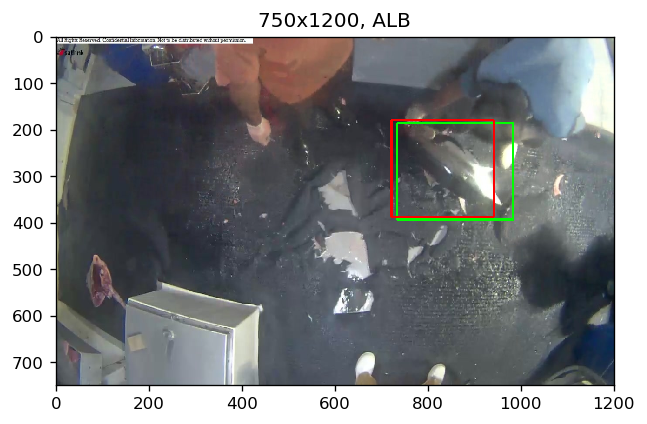

In [278]:
plt.figure(figsize=(6, 6), dpi=120)
img = draw_boxes(example, decoded[:3], (IMG_WIDTH, IMG_HEIGHT))
plt.imshow(img)
plt.title('{}x{}, {}'.format(img.shape[0], img.shape[1], idx_to_labels[decoded[0]['label'].argmax()]));

## Агрегация результатов

In [ ]:
# TODO: предскажите класс рыбы для фотографии из тестовой выборки
#
# Подготовьте файл с предсказаниями вероятностей для каждой фотографии:
# image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT
# img_00001.jpg,1,0,0,0,0,...,0
# img_00002.jpg,0.3,0.1,0.6,0,...,0